<a href="https://colab.research.google.com/github/Dhanush-cm/Plant-Disease-Classification-Deep-Learning-/blob/main/dl_review2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

title: plant disease classification

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


Found 41276 files belonging to 2 classes.
Using 33021 files for training.
Found 41276 files belonging to 2 classes.
Using 8255 files for validation.
Train batches: 1032
Validation batches: 129
Test batches: 129


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 131s 120ms/step - accuracy: 0.5043 - auc: 0.4984 - loss: 0.6956 - precision: 0.5051 - recall: 0.8331 - val_accuracy: 0.5085 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 32s 31ms/step - accuracy: 0.4991 - auc: 0.4960 - loss: 0.6932 - precision: 0.5006 - recall: 0.5488 - val_accuracy: 0.5073 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - accuracy: 0.5023 - auc: 0.5026 - loss: 0.6932 - precision: 0.5069 - recall: 0.6261 - val_accuracy: 0.5070 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - accuracy: 0.5006 - auc: 0.5002 - loss: 0.6932 - precision: 0.5035 - recall: 0.7188 - val_accuracy: 0.5070 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_r

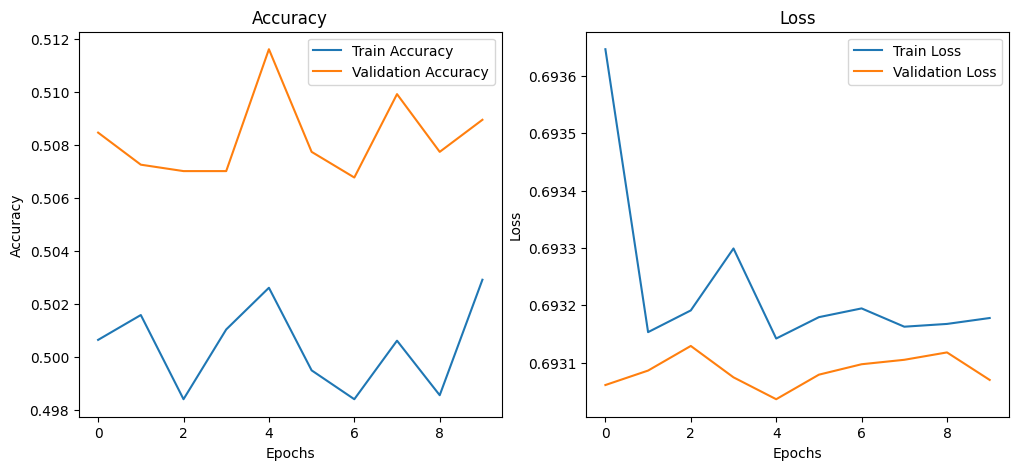

129/129 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step


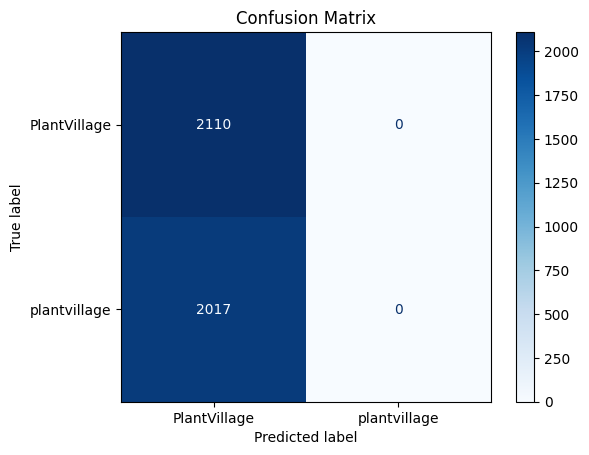

In [ ]:
#step 1 Imports & basic settings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
dataset_dir = '/kaggle/input/plantdisease'
img_size = (128, 128)
batch_size = 32
seed = 123
#step 2 reate datasets (train / val / test)
# Load datasets: train (80%), val+test (20%)
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Split val_test_ds into val (50%) and test (50%)
val_batches = int(len(val_test_ds) * 0.5)
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))
print("Test batches:", len(test_ds))

# Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=img_size+(3,)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

# Train the model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)

# Evaluate on test set
test_loss, test_acc, test_prec, test_rec, test_auc = model.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")
print(f"Test AUC: {test_auc:.4f}")

# Plot training curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion matrix on test
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = (y_pred_probs > 0.5).astype('int32').flatten()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

To improve the model's performance, we can apply data augmentation to the training dataset. This will help the model generalize better and prevent overfitting. We can use layers like `RandomFlip`, `RandomRotation`, and `RandomZoom` within the model definition.

Epoch 1/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.4986 - auc: 0.4985 - loss: 0.6949 - precision: 0.5018 - recall: 0.6189 - val_accuracy: 0.5097 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 75s 35ms/step - accuracy: 0.5000 - auc: 0.5004 - loss: 0.6932 - precision: 0.5037 - recall: 0.6208 - val_accuracy: 0.5073 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 37s 35ms/step - accuracy: 0.5039 - auc: 0.5092 - loss: 0.6931 - precision: 0.4941 - recall: 0.5318 - val_accuracy: 0.5070 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 41s 36ms/step - accuracy: 0.4970 - auc: 0.4994 - loss: 0.6933 - precision: 0.4985 - recall: 0.6046 - val_accuracy: 0.5085 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_rec

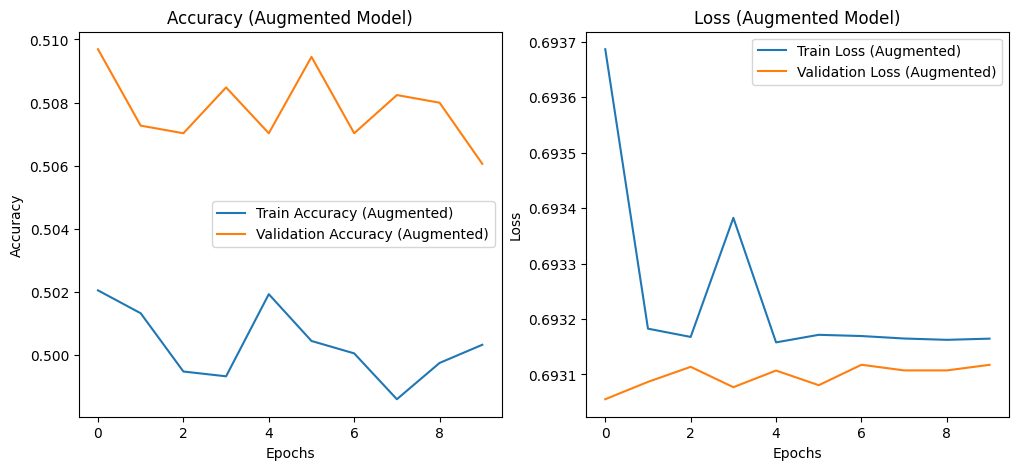

129/129 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step


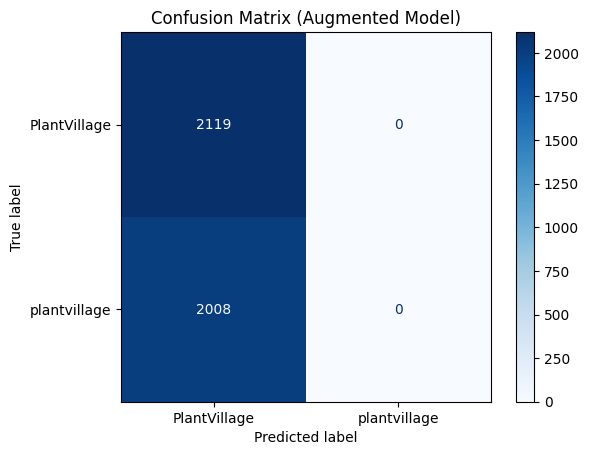

In [ ]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Define CNN model with data augmentation
model_augmented = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])

# Compile the augmented model
model_augmented.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc'),
    ]
)

# Train the augmented model
history_augmented = model_augmented.fit(train_ds, validation_data=val_ds, epochs=10)

# Evaluate on test set
test_loss_aug, test_acc_aug, test_prec_aug, test_rec_aug, test_auc_aug = model_augmented.evaluate(test_ds)
print(f"Augmented Test Loss: {test_loss_aug:.4f}")
print(f"Augmented Test Accuracy: {test_acc_aug:.4f}")
print(f"Augmented Test Precision: {test_prec_aug:.4f}")
print(f"Augmented Test Recall: {test_rec_aug:.4f}")
print(f"Augmented Test AUC: {test_auc_aug:.4f}")

# Plot training curves for augmented model
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history_augmented.history['accuracy'], label='Train Accuracy (Augmented)')
plt.plot(history_augmented.history['val_accuracy'], label='Validation Accuracy (Augmented)')
plt.title('Accuracy (Augmented Model)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_augmented.history['loss'], label='Train Loss (Augmented)')
plt.plot(history_augmented.history['val_loss'], label='Validation Loss (Augmented)')
plt.title('Loss (Augmented Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion matrix on test for augmented model
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_pred_probs_aug = model_augmented.predict(test_ds)
y_pred_aug = (y_pred_probs_aug > 0.5).astype('int32').flatten()

cm_aug = confusion_matrix(y_true, y_pred_aug)
disp_aug = ConfusionMatrixDisplay(confusion_matrix=cm_aug, display_labels=train_ds.class_names)
disp_aug.plot(cmap='Blues')
plt.title('Confusion Matrix (Augmented Model)')
plt.show()